In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

from model import *

In [2]:
file_name = 'mimmo/mimmo.h5'
hf = h5py.File(file_name,'r')

print('Keys: ', list(hf.keys()))
print('Attrs: ', dict(hf.attrs),'\n')
print(hf['ismrmrd_header'])
print(hf['kspace'])
print(hf['reconstruction_esc'])
print(hf['reconstruction_rss'])

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs:  {'acquisition': 'CORPDFS_FBK', 'max': 0.000851878253624366, 'norm': 0.0596983310320022, 'patient_id': '0beb8905d9b7fad304389b9d4263c57d5b069257ea0fdc5bf7f2675608a47406'} 

<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (36, 640, 372), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (36, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (36, 320, 320), type "<f4">


In [3]:
total_kspace = hf['kspace'][()]     #Takes all the kspace
print(total_kspace.dtype)
print(total_kspace.shape)

complex64
(36, 640, 372)


In [4]:
#Takes single layer of the kspace image
slice_kspace = total_kspace[35] #Ogni valore tra 0-35 ritorna un'immagine diversa
print(slice_kspace.shape,total_kspace.shape)

(640, 372) (36, 640, 372)


(640, 372)


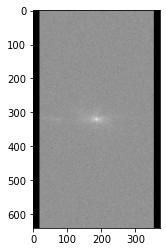

In [5]:
def show_coils(data, cmap=None): #Shows image in kspace
    fig = plt.figure()
    print(data.shape)
    plt.imshow(data, cmap=cmap)
    
show_coils(np.log(np.abs(slice_kspace) + 1e-9),cmap='gray')

float32


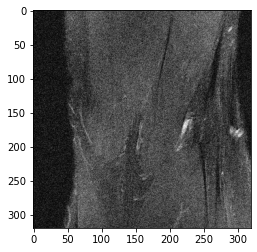

In [6]:
ready_zerofilled = hf['reconstruction_esc'][35]
print(ready_zerofilled.dtype)
fig = plt.figure()
plt.imshow(ready_zerofilled, cmap='gray') #The real image already reconstructed from kspace (FULLY SAMPLED)

ifft masked space,  torch.Size([640, 372, 2])
crop_ifft_mk shape,  torch.Size([320, 320, 2])
abs masked space,  torch.Size([320, 320])
mask,  torch.Size([1, 372, 1])
mask2,  torch.Size([1, 320, 1])
masked_kspace,  torch.Size([640, 372, 2])
original image shape,  torch.Size([640, 372, 2])



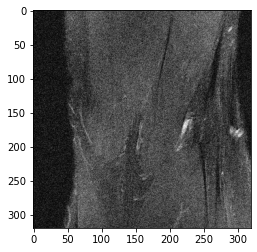

In [11]:
from fastmri.data.subsample import RandomMaskFunc

mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])

#TODO: CROP THE SLICE KSPACE HERE?
crop_kspace = T.complex_center_crop(T.to_tensor(slice_kspace), (320,320))

masked_kspace, mask = T.apply_mask(T.to_tensor(slice_kspace), mask_func)   # Apply the mask to k-space
_, mask2 = T.apply_mask(crop_kspace, mask_func)

ifft_masked_kspace = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
crop_ifft_mk = T.complex_center_crop(ifft_masked_kspace, (320,320))
abs_masked_kspace = fastmri.complex_abs(crop_ifft_mk)   # Compute absolute value to get a real image

print("ifft masked space, ",ifft_masked_kspace.shape)
print("crop_ifft_mk shape, ",crop_ifft_mk.shape)
print("abs masked space, ",abs_masked_kspace.shape)
print("mask, ",mask.shape)
print("mask2, ",mask2.shape)
print("masked_kspace, ",masked_kspace.shape)
 
original_img = fastmri.ifft2c(T.to_tensor(slice_kspace))   #Inverse fourier transf. to the original image
crop_original_img = T.complex_center_crop(original_img, (320,320))
abs_original_img = fastmri.complex_abs(crop_original_img)
print("original image shape, ",original_img.shape)

fig = plt.figure()
plt.imshow(abs_original_img, cmap='gray')

In [12]:
mimmo = Net()
#mimmo.cuda()

input1 = crop_ifft_mk.unsqueeze(0).unsqueeze(0) #ifft_masked_kspace.unsqueeze(0).unsqueeze(0)
input2 = crop_original_img.unsqueeze(0).unsqueeze(0)
print(input1.shape)
print(input2.shape)

mimmone = mimmo(input1,input2,mask2)

torch.Size([1, 1, 320, 320, 2])
torch.Size([1, 1, 320, 320, 2])
CYCLE ( 1 )


torch.Size([1, 1, 320, 320, 2])
torch.float32


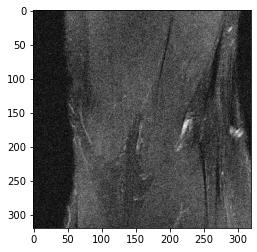

In [13]:
print(mimmone.shape)

figuraoutput = mimmone.squeeze(0).squeeze(0)
print(figuraoutput.dtype)
sampled_image = fastmri.ifft2c(figuraoutput)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image

fig = plt.figure()
plt.imshow(sampled_image_abs.detach().numpy(), cmap='gray')